In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm

# Read data

In [2]:
listings_file_path = '../data/airbnb/listings.csv'
al_file_path = '../data/Alojamento_Local.csv'
df_al = pd.read_csv(al_file_path)
df_listings = pd.read_csv(listings_file_path)

C:\Users\david\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# General schema

![Star schema](schema.png)

# Exploratory data analysis

In [3]:
def missing_data(df, columns):
    df_graph = df[columns]
    #missing data
    total = df_graph.isnull().sum().sort_values(ascending=False)
    percent = (df_graph.isnull().sum()/df_graph.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print(missing_data)
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='index',y = 'Percent', data= missing_data.reset_index())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return ax

def feature_dist(df, column_name):
    plt.figure(figsize=(15,4))
    sns.distplot(df[column_name] , fit=norm)

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[column_name])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('{} distribution'.format(column_name))
    plt.show()

#IN BAR CHARTS, SET PERCENTAGES ABOVE EACH BAR
def set_bar_percentage(ax, df):
    for p in ax.patches:
        ax.annotate(f"{p.get_height() * 100 / df.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
          ha='center', va='center', rotation=0, xytext=(0, 10),
          textcoords='offset points')
        
#IN BAR CHARTS, SET THE VALUE ABOVE EACH BAR
def set_bar_amount(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate("{0:.2f}%".format(p.get_height()*100), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', rotation=0, xytext=(0, 10),
            textcoords='offset points')
        
#Simple plot
def simple_plot(df,column):
    bx = sns.catplot(x=column,data=df, kind='count')
    (bx.set_axis_labels(column, "Count")
        .set_titles("{col_name} {col_var}")
        .despine(left=True))

## Merge df_listings with alojamento_local.csv

In [4]:
def intTryParse(value):
    try:
        a = int(value)
        return True
    except ValueError:
        return False

In [5]:
#get only listings where 'license' is not null && != 'Exempt'
df_listings_with_license = df_listings[(~df_listings['license'].isnull())&(df_listings['license'] != 'Exempt')]

#string replace
df_listings_with_license['NrRNAL'] = [s.replace('/AL','').replace('.','') for s in df_listings_with_license['license']]

#get only records where license nr can be converted to int 
df_listings_with_license = df_listings_with_license[[intTryParse(s) for s in df_listings_with_license['NrRNAL']]]

#convert NrRNAL to int before merge the two dataframes
df_listings_with_license['NrRNAL'] = df_listings_with_license['NrRNAL'].astype(np.int64)

#inner join two dataframes
df_result = pd.merge(df_listings_with_license, df_al, how='inner', on='NrRNAL')

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [6]:
print('dataset size: {}'.format(len(df_result)))

dataset size: 17168


## Missing data

              Total   Percent
CodigoPostal     21  0.001223
Concelho          0  0.000000
Freguesia         0  0.000000
Endereco          0  0.000000


Text(0.5, 1.0, 'Location dimension missing data')

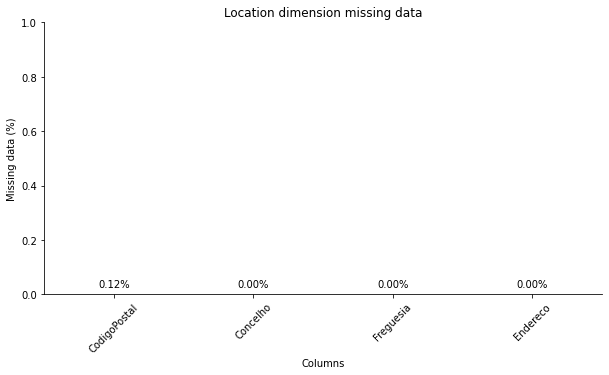

In [8]:
columns = [
    'Endereco',
    'Freguesia',
    'CodigoPostal',
    'Concelho'
    ]
ax = missing_data(df_result,columns)
set_bar_amount(ax)
ax.set_xlabel('Columns')
ax.set_ylabel('Missing data (%)')
plt.ylim(0,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Location dimension missing data')

**Street**

Some repeated addresses. Reapeated 'Rua'.

In [9]:
print(df_result['Endereco'].value_counts())

1ª Rua José Joaquim Fernandes 76               27
Rua Rua Fradesso da Silveira 79 1º e sotão     25
Rua Rua Fanqueiros 150 3.º                     23
Urbanização Pérola do Oceano 10 Rc D           18
Avenida Avenida Visconde Valmor 20 1º Dto.     16
                                               ..
Rua Rua 9 de Abril 99 1 Esq                     1
Rua Rua Quirino da Fonseca 11 1º Esq.           1
Travessa Travessa do Jordão 13                  1
Rua Rua Alberto de Oliveira 33 1º Dto.          1
Rua Rua Martim Vaz 60 4º                        1
Name: Endereco, Length: 13112, dtype: int64


**Parish**

No missing values. Possibly some redundant data and parishes outside of Lisbon.

In [10]:
print(df_result['Freguesia'].value_counts())

Misericórdia                                                    2407
Santa Maria Maior (Lisboa)                                      2137
Santo António                                                   1101
Arroios (Lisboa)                                                1029
União das freguesias de Cascais e Estoril                       1003
                                                                ... 
Vau                                                                1
Areosa                                                             1
Moita dos Ferreiros                                                1
Ferragudo                                                          1
União das freguesias de Safara e Santo Aleixo da Restauração       1
Name: Freguesia, Length: 245, dtype: int64


**County**

Some counties are not even in Lisbon. Get fixed list of counties and keep only those entries.

In [11]:
print(df_result['Concelho'].value_counts())

Lisboa             12998
Cascais             1337
Mafra                842
Sintra               837
Lourinhã             191
                   ...  
Ponte de Sor           1
Peso da Régua          1
Covilhã                1
Terras de Bouro        1
Santarém               1
Name: Concelho, Length: 88, dtype: int64


**Zip_code**

- Some missing values - 21
- Some repeated values

In [12]:
print(df_result['CodigoPostal'].value_counts())

1200-148    60
1100-232    56
1100-376    54
1200-425    40
2655-333    36
            ..
2750-785     1
2725-595     1
1400-136     1
3870-350     1
1000-235     1
Name: CodigoPostal, Length: 4631, dtype: int64
